[63, 114, 26]
[68, 108, 53]


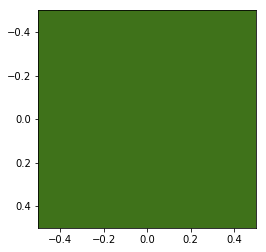

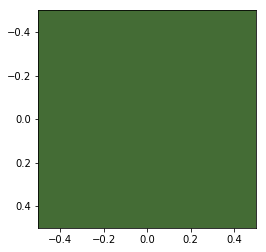

In [200]:
import matplotlib.pyplot as plt
import random
from collections import namedtuple
from operator import itemgetter
import timeit

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.offline as py
import plotly.graph_objs as go




n = 1000
plot = True

def distance(v1, v2):
    res = 0
    for i in range(0, len(v1)):
        res = res + (v1[i]-v2[i])*(v1[i]-v2[i])
    
    return res

def generate():
    points = []

    for i in range(n):
        points.append([random.randint(0,255) for i in range(3)])

    return points

def bruteforce(points):
    n = len(points)

    res = []
    
    for q in range(n//2, n):
        best = 0
        for p in range(0,n//2):
            if distance(points[p], points[q])<distance(points[best], points[q]):
                best = p
        
        res.append(points[best])
    
    return res

def kdtree(points):
    n = len(points)
    
    class Node(namedtuple('Node', 'axis point left_child right_child')):
        """a node"""
    
    def build_kdtree(points, depth=0):
        try:
            d = len(points[0])
        except IndexError as e:
            return None
        
        axis = depth % d
        points.sort(key=itemgetter(axis))
        
        mid = len(points)//2
        
        return Node(
            axis=axis,
            point=points[mid],
            left_child=build_kdtree(points[:mid], depth+1),
            right_child=build_kdtree(points[mid+1:], depth+1)
        )
    
    root = build_kdtree(points[:n//2])
    
    def query(node, point, _best=None):
        if node is None:
            return _best
        
        if _best is None:
            _best = node.point

        if distance(point,_best)>distance(point,node.point):
            _best = node.point
            
        if node.point[node.axis]<=point[node.axis]:
            _best = query(node.right_child, point, _best)
        else:
            _best = query(node.left_child, point, _best)
        
        projection = list(point)
        projection[node.axis]=node.point[node.axis]
        
        if distance(point, projection)<distance(point, _best):
            if node.point[node.axis]<=point[node.axis]:
                _best = query(node.left_child, point, _best)
            else:
                _best = query(node.right_child, point, _best)

        return _best
    
 
    
    res = []
    for i in range(n//2, n):
        res.append(query(root, points[i]))
       
    return res

points = generate()

if not plot:
    print(n, "random points, the first half contains the given points and the second half the queries")
    print("kdtree =", timeit.timeit("kdtree(points)", setup="from __main__ import kdtree, points", number=1))
    print("bruteforce =", timeit.timeit("bruteforce(points)", setup="from __main__ import bruteforce, points", number=1))
else:
    speed1, speed2 = [], []
    for i in range(1, n//2+1, 5):
        speed1.append(timeit.timeit("kdtree(points[:2*i])", setup="from __main__ import kdtree, points, i", number=1))
        speed2.append(timeit.timeit("bruteforce(points[:2*i])", setup="from __main__ import bruteforce, points, i", number=1))
    
    trace1 = go.Scatter(
        x = list(range(1,n//2+1, 5)),
        y = speed1,
        name="kdtree"
    )
    
    trace2 = go.Scatter(
        x = list(range(1,n//2+1, 5)),
        y = speed2,
        name="bruteforce"
    )

    data = [trace1, trace2]

    py.iplot(data, filename='basic-line')

def show(color):
    cpy=list(color)
    cpy[0] = cpy[0]/255
    cpy[1] = cpy[1]/255
    cpy[2] = cpy[2]/255
    
    print(color)
    
    plt.figure()
    plt.imshow([[cpy]])

res1=kdtree(points)
    
show(res1[0])
show(points[n//2])